In [11]:
######################################################################
# Semi-Supervised Classification of Graph Nodes using Exponential Decay
# L42: Assessment 2
# Jan Ondras (jo356), Trinity College
######################################################################
# Baseline MLP training, validation and testing, Citeseer dataset
#############################################################################################################
#############################################################################################################
# Load data 
#############################################################################################################

import keras
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import time
import os
from gcn.utils import *

dataset_type = 'citeseer'

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset_type)

if dataset_type == 'citeseer':
    N_classes = 6
    N_features = 3703
    N_nodes = 3327
    N_edges = 4676 #4732 - incorrect in GCN paper !
    if (N_classes != y_train.shape[1] or N_features != features.shape[1] or N_nodes != features.shape[0] 
            or N_edges != (np.sum(adj.toarray().diagonal()) + np.sum(adj.todense()))/2. ):
        raise ValueError("Dataset dimensions differ from expected!")
else:
    raise ValueError("Dataset not supported!")
print dataset_type, "dataset:", "#classes =", N_classes, ", #features =", N_features, ", #nodes =", N_nodes, ", #edges =", N_edges

X_train = features[train_mask].toarray()
X_val = features[val_mask].toarray()
X_test = features[test_mask].toarray()
y_train = y_train[train_mask]
y_val = y_val[val_mask]
y_test = y_test[test_mask]

print "Feature set shapes (train, valid, test):", X_train.shape, X_val.shape, X_test.shape
print "Labels shapes (train, valid, test):", y_train.shape, y_val.shape, y_test.shape
print y_train.shape[0]*100./N_nodes, y_val.shape[0]*100./N_nodes, y_test.shape[0]*100./N_nodes

citeseer dataset: #classes = 6 , #features = 3703 , #nodes = 3327 , #edges = 4676
Feature set shapes (train, valid, test): (120, 3703) (500, 3703) (1000, 3703)
Labels shapes (train, valid, test): (120, 6) (500, 6) (1000, 6)
3.60685302074 15.0285542531 30.0571085062


In [ ]:
# Show graph of the network
G = nx.from_scipy_sparse_matrix(adj)
# pos = nx.spring_layout(G)
plt.figure(figsize=(15,15))
nx.draw(G, node_size=5)
plt.show()

In [2]:
#############################################################################################################
# Baseline MLP, validate, DONE
#############################################################################################################
# Tune #hidden layers and #hidden units (same for each layer)
# Dropout fixed

epochs = 10000
train_batch_size = len(X_train)
val_batch_size = len(X_val)
test_batch_size = len(X_test)

N_runs = 100
dropout = 0.5

N_hl_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # range of numbers of hidden layers
N_hu_range = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80] # range of numbers of units per hidden layer
print "Validation over ", len(N_hl_range) * len(N_hu_range), "=", len(N_hl_range), "x", len(N_hu_range), "parameter settings"
vals = np.zeros((len(N_hl_range), len(N_hu_range)))
vals_std = np.zeros((len(N_hl_range), len(N_hu_range)))

for a, N_hl in enumerate(N_hl_range):
    for b, N_hu in enumerate(N_hu_range):
        st = time.time()
        # Create model
        model = Sequential()
        model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
        model.add(Dropout(dropout))
        for i in range(1, N_hl):
            model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform'))
            model.add(Dropout(dropout))
        model.add(Dense(N_classes, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
        #print model.summary()
        early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

        vals_actual = []
        for i in range(N_runs):
            model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
                       validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

            vals_actual.append( model.evaluate(X_val, y_val, batch_size=val_batch_size, verbose=0)[1] )

        vals[a][b] = np.mean(vals_actual)
        vals_std[a][b] = np.std(vals_actual)
        print "Time taken: ", time.time()-st, (time.time()-st)/60. 
# Total ~ 1.5 hod

Validation over  150 = 10 x 15 parameter settings
Time taken:  32.426651001 0.540448315938
Time taken:  35.4217522144 0.590363419056
Time taken:  32.5707840919 0.542847216129
Time taken:  28.3178520203 0.471967899799
Time taken:  37.7108020782 0.628517035643
Time taken:  33.8519601822 0.564199801286
Time taken:  33.4277799129 0.557130066554
Time taken:  35.2805221081 0.588013799985
Time taken:  38.6531620026 0.644223499298
Time taken:  38.2238948345 0.637065784136
Time taken:  38.5173950195 0.641957199574
Time taken:  37.4289009571 0.623815532525
Time taken:  41.4279708862 0.690468132496
Time taken:  39.0019080639 0.650032369296
Time taken:  39.8033900261 0.663390767574
Time taken:  38.6758730412 0.644598599275
Time taken:  39.6296820641 0.66049536864
Time taken:  34.161411047 0.569359819094
Time taken:  38.2330408096 0.637217748165
Time taken:  41.4957931042 0.691598848502
Time taken:  38.0572099686 0.634287333488
Time taken:  41.3895580769 0.689828316371
Time taken:  44.6486189365 0.

In [3]:
#############################################################################################################
# Save the results ! IDs 0,1, are used
# TODO save as 1
ID = 0 # zeroth trial, smaller # of hidden sizes
ID = 1 # first ok trial , more # of hidden sizes

if os.path.exists('./../../../Dataset/baseline_' + str(ID) + '_Citeseer.npz'):
    raise NameError("Set saveID not in use!")
np.savez('./../../../Dataset/baseline_' + str(ID) + '_Citeseer.npz', vals=vals, vals_std=vals_std, 
         N_hl_range=N_hl_range, N_hu_range=N_hu_range, N_runs=N_runs, dropout=dropout, epochs=epochs)

In [2]:
#############################################################################################################
# Load tuned parameters - from Baseline MLP validation on CITESEER dataset
#############################################################################################################

ID = 0 # zeroth trial,  smaller # of hidden sizes
ID = 1 # first ok trial, higher # of hidden sizes

data = np.load('./../../../Dataset/baseline_' + str(ID) + '_Citeseer.npz')
vals = data['vals']
vals_std = data['vals_std']
N_hl_range = data['N_hl_range']
N_hu_range = data['N_hu_range']
N_runs = data['N_runs']
dropout = data['dropout']
epochs = data['epochs']

train_batch_size = len(X_train)
val_batch_size = len(X_val)
test_batch_size = len(X_test)

best_N_hl = N_hl_range[np.argmax(vals) // len(N_hu_range)]
best_N_hu = N_hu_range[np.argmax(vals) % len(N_hu_range)]

print "# hidden layers range", N_hl_range
print "# hidden units range", N_hu_range
print "Optimal number of hidden layers: ", best_N_hl
print "Optimal number of hidden units: ",  best_N_hu
print "Best validation accuracy: ", np.max(vals), vals[np.argmax(vals) // len(N_hu_range), np.argmax(vals) % len(N_hu_range)], vals.shape, np.argmax(vals)
print "dropout", dropout, "\tN_runs", N_runs

# hidden layers range [ 1  2  3  4  5  6  7  8  9 10]
# hidden units range [10 15 20 25 30 35 40 45 50 55 60 65 70 75 80]
Optimal number of hidden layers:  3
Optimal number of hidden units:  50
Best validation accuracy:  0.556840002537 0.556840002537 (10, 15) 38
dropout 0.5 	N_runs 100


0.0914600000158


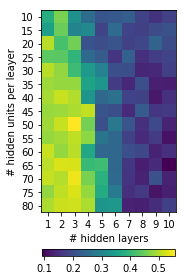

Baseline method: validation accuracy in terms of hidden layer size (x) and number of hidden units per layer (y)


In [10]:
vmin= np.min(vals)
vmax = np.max(vals)
# mid_val = 0.15
# cmap = 'hot_r' #'coolwarm'
# vmax = 0.695440005958
# vmin = 0.0842999996617
print vmin

plt.figure()
plt.imshow(vals.T) # , vmax = 0.6 , cmap=cmap
plt.xticks(range(len(N_hl_range)), N_hl_range)
plt.yticks(range(len(N_hu_range)), N_hu_range)
plt.xlabel('# hidden layers')
plt.ylabel('# hidden units per leayer')
plt.colorbar(orientation="horizontal", fraction=0.027)
plt.tight_layout()
plt.show()
print "Baseline method: validation accuracy in terms of hidden layer size (x) and number of hidden units per layer (y)"

In [7]:
#############################################################################################################
# Train and Test, again averaged over 100 runs with rand init
#############################################################################################################

# best_N_hl   # from above
# best_N_hu

# Create model
model = Sequential()
model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
model.add(Dropout(dropout))
for i in range(1, best_N_hl):
    model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout))
model.add(Dense(N_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print model.summary()
early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

test_acc = []
for i in range(N_runs):
    model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
               validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

    test_acc.append( model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)[1] )

print "Test set accuracy: ", np.mean(test_acc), "+/-", np.std(test_acc)
print "Baseline accuracy (chance level): ", 1./N_classes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_980 (Dense)            (None, 50)                185200    
_________________________________________________________________
dropout_829 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_981 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_830 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_982 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_831 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_983 (Dense)            (None, 6)                 306       
Total para

In [ ]:
Test set accuracy:  0.507599999309 +/- 0.00710351817853
Baseline accuracy (chance level):  0.166666666667
